### Data Source : https://www.kaggle.com/snap/amazon-fine-food-reviews

## Objective : 

Given a review, determine whether the review is positive or not


#### How to determine

we could use rating 4 or 5 as positive and 1 or 2 negative. A review of 3 is neutral and ignored

#### Let's import the library

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import sqlite3
import nltk

import string
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve,auc
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.metrics import roc_auc_score
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score


#### Let's Read the data

In [2]:
#use the SQLite Table to read data

conn = sqlite3.connect('database.sqlite')

filtered_data = pd.read_sql_query("""select * from reviews where score !=3 Limit 5000""",conn)

In [3]:
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review

#### We use score as rating 

In [4]:
def partition(x):
    if x < 3:
        return 0
    return 1
actual_score = filtered_data['Score']
positiveNegative = actual_score.map(partition)
filtered_data['Score'] = positiveNegative
print("Number of data point in our data",filtered_data.shape)
filtered_data.head()

Number of data point in our data (5000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
filtered_data['Score'].value_counts()

1    4187
0     813
Name: Score, dtype: int64

In [6]:
filtered_data.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

We have to find the userid who gave review more than one time. So we will use groupby clause

In [7]:
display = pd.read_sql_query("""select 
UserId, ProductId, ProfileName,Score,Time,Text,Count(*)
from Reviews Group by userId 
Having Count(*)>1""",conn)

In [8]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Score,Time,Text,Count(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,2,1331510400,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",5,1342396800,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1,1348531200,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,5,1346889600,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1,1348617600,I didnt like this coffee. Instead of telling y...,2


In [9]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Score,Time,Text,Count(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",5,1334707200,I was recommended to try green tea extract to ...,5


In [10]:
display['Count(*)'].sum()

393063

### Exploratory Data Analysis

In [11]:
print(filtered_data['UserId'].value_counts())

A3PJZ8TU8FDQ1K    5
A31N6KB160O508    5
AY12DBB0U420B     5
A3OXHLG6DIBRW8    5
A2NLZ3M0OJV9NX    4
                 ..
A3O1I3KB7L1R9S    1
A3UCN2RGY7O6S1    1
A3PXSG75NMXNUF    1
AYMV2T86WIXVD     1
A2VDUVKIEMEBMF    1
Name: UserId, Length: 4824, dtype: int64


In [12]:
display_data = pd.read_sql_query("""select
* from Reviews where Score !=3 and
UserId = "A31N6KB160O508"
ORDER BY ProductId""",conn)
display_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,473869,B0005YW8C4,A31N6KB160O508,Fran W.,0,0,5,1323820800,Good taste and quaility,Delicious as usual for this cookie. Love them....
1,491579,B0005YW8K6,A31N6KB160O508,Fran W.,0,0,5,1323820800,Good taste and quaility,Delicious as usual for this cookie. Love them....
2,253563,B0005Z6ZK4,A31N6KB160O508,Fran W.,1,12,1,1309478400,Seal on item not intact,Had to get a refund from Amazon. Received the ...
3,508458,B00099XN7O,A31N6KB160O508,Fran W.,0,0,5,1216339200,"Delicious,creamy,substantial meal helper",I hiave made this both separately and with chi...
4,13721,B000AY9U20,A31N6KB160O508,Fran W.,2,2,5,1204502400,Excellent taste and shipping,I received these recently without any problem ...


Observation : We found there are many duplicate entries with same UserId, ProfileName,Text

### Sorted the dataset order by ProductId

In [13]:
sorted_data = filtered_data.sort_values("ProductId",axis=0,ascending = True,inplace =False,kind = "quicksort",na_position = 'last')


In [14]:
#deduplication of entries
final = sorted_data.drop_duplicates(subset = {"UserId","ProductId","ProfileName","Text"},keep = 'first',inplace=False)
final.shape

(4993, 10)

In [15]:
#checking to see how much % of data still remains

(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.86

Observation : We found there are two id for that helpfulnessNumerator is greater than helpfulnessDenominator which is not practically  possible.Hence we remove these two rows for calculations

In [16]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", conn)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [17]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

### Let's take final data

In [18]:
final.shape

(4993, 10)

In [19]:
final['Score'].value_counts()

1    4183
0     810
Name: Score, dtype: int64

Observation : Total count for Positive Review : 4183 and Negative Review : 810 

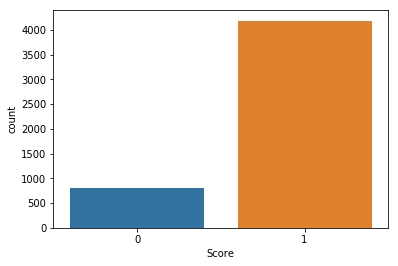

In [20]:
sns.countplot(x = 'Score',data = final)

#### Text  Preprocessing

In [21]:
#printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
These chips are quite tasty and the price is right.  Packaged very well, would buy again.
After eating TANG's chocolate and double-chocolate cookies, all other cookies will taste like expired, tepid dogfood to you. Her cookies will enhance your life in ways you never dreamed possible. Tim Horton's, Timothy's, Second Cup, Starbucks, Treats and those horrid packaged cookies at Zupas are just pathetic imitators to the grandeur that is a TANG cookie. HER COOKIES ARE DA BOMB!!! A+++++++ Hawt damn!
My daughter, living and working in DC this summer, introduced me to this product while home for a visit.  She encouraged me to give the plain version (just pure coconut water) a chance first, and by the second container, I understood t

In [22]:
#remove the URL from  text python
import re
sent_0 = re.sub(r"http\S+","",sent_0)
sent_1000 = re.sub(r"http\S+","",sent_1000)
sent_1500 = re.sub(r"http\S+","",sent_1500)
sent_4900 = re.sub(r"http\S+","",sent_4900)
print(sent_0)
print(sent_1000)
print(sent_1500)
print(sent_4900)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
These chips are quite tasty and the price is right.  Packaged very well, would buy again.
After eating TANG's chocolate and double-chocolate cookies, all other cookies will taste like expired, tepid dogfood to you. Her cookies will enhance your life in ways you never dreamed possible. Tim Horton's, Timothy's, Second Cup, Starbucks, Treats and those horrid packaged cookies at Zupas are just pathetic imitators to the grandeur that is a TANG cookie. HER COOKIES ARE DA BOMB!!! A+++++++ Hawt damn!
My daughter, living and working in DC this summer, introduced me to this product while home for a visit.  She encouraged me to give the plain version (just pure coconut water) a chance first, and by the second container, I understood the amazing qualities of this drink.  I felt so refreshed, hydrated, 

In [23]:
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0,"lxml")
text = soup.get_text()
print(text)
print("="*100)

soup = BeautifulSoup(sent_1000,"lxml")
text = soup.get_text()
print(text)
print("="*50)

soup= BeautifulSoup(sent_1500,"lxml")
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900,"lxml")
text = soup.get_text()
print(text)
print("="*50)

Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
These chips are quite tasty and the price is right.  Packaged very well, would buy again.
After eating TANG's chocolate and double-chocolate cookies, all other cookies will taste like expired, tepid dogfood to you. Her cookies will enhance your life in ways you never dreamed possible. Tim Horton's, Timothy's, Second Cup, Starbucks, Treats and those horrid packaged cookies at Zupas are just pathetic imitators to the grandeur that is a TANG cookie. HER COOKIES ARE DA BOMB!!! A+++++++ Hawt damn!
My daughter, living and working in DC this summer, introduced me to this product while home for a visit.  She encouraged me to give the plain version (just pure coconut water) a chance first, and by the second container, I understood the amazing qualities of this drink.  I felt so refreshed, hydrated, and healthy!

In [24]:
import re

def decontracted(phrase):
    phrase = re.sub(r"won't","will not",phrase)
    phrase = re.sub(r"can't","can not",phrase)
    phrase=  re.sub(r"\'s","is",phrase)
    phrase = re.sub(r"\'re","are",phrase)
    phrase= re.sub(r"\'not","not",phrase)
    phrase = re.sub(r"\'d","would",phrase)
    phrase = re.sub(r"\'ll","will",phrase)
    phrase = re.sub(r"\'ve","have",phrase)
    phrase = re.sub(r"\'m","am",phrase)
    return phrase

In [25]:
sent_0 = decontracted(sent_0)
print(sent_0)
print("="*50)

sent_1000 = decontracted(sent_1000)
print(sent_1000)
print("="*50)

sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

sent_4900 = decontracted(sent_4900)
print(sent_4900)
print("="*50)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
These chips are quite tasty and the price is right.  Packaged very well, would buy again.
After eating TANGis chocolate and double-chocolate cookies, all other cookies will taste like expired, tepid dogfood to you. Her cookies will enhance your life in ways you never dreamed possible. Tim Hortonis, Timothyis, Second Cup, Starbucks, Treats and those horrid packaged cookies at Zupas are just pathetic imitators to the grandeur that is a TANG cookie. HER COOKIES ARE DA BOMB!!! A+++++++ Hawt damn!
My daughter, living and working in DC this summer, introduced me to this product while home for a visit.  She encouraged me to give the plain version (just pure coconut water) a chance first, and by the second container, I understood the amazing qualities of this drink.  I felt so refreshed, hydrated, 

In [26]:
#remove words with numbers python
sent_0 = re.sub("\S*\d\S*","",sent_0).strip()
print(sent_0)

sent_1000 = re.sub("\S*\d\S*","",sent_1000).strip()
print(sent_1000)

sent_1500 = re.sub("\S*\d\S*","",sent_1500).strip()
print(sent_1500)

sent_4900 = re.sub("\S*\d\S*","",sent_4900).strip()
print(sent_4900)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
These chips are quite tasty and the price is right.  Packaged very well, would buy again.
After eating TANGis chocolate and double-chocolate cookies, all other cookies will taste like expired, tepid dogfood to you. Her cookies will enhance your life in ways you never dreamed possible. Tim Hortonis, Timothyis, Second Cup, Starbucks, Treats and those horrid packaged cookies at Zupas are just pathetic imitators to the grandeur that is a TANG cookie. HER COOKIES ARE DA BOMB!!! A+++++++ Hawt damn!
My daughter, living and working in DC this summer, introduced me to this product while home for a visit.  She encouraged me to give the plain version (just pure coconut water) a chance first, and by the second container, I understood the amazing qualities of this drink.  I felt so refreshed, hydrated, and heal

In [27]:
#remove special character
sent_0 = re.sub('[^A-Za-z0-9]+',' ',sent_0)
print(sent_0)

sent_1000 = re.sub('[^A-Za-z0-9]+',' ',sent_1000)
print(sent_1000)

sent_1500 = re.sub('[^A-Za-z0-9]+',' ',sent_1500)
print(sent_1500)

sent_4900 = re.sub('[^A-Za-z0-9]+',' ',sent_4900)
print(sent_4900)

Why is this when the same product is available for here br br The Victor and traps are unreal of course total fly genocide Pretty stinky but only right nearby 
These chips are quite tasty and the price is right Packaged very well would buy again 
After eating TANGis chocolate and double chocolate cookies all other cookies will taste like expired tepid dogfood to you Her cookies will enhance your life in ways you never dreamed possible Tim Hortonis Timothyis Second Cup Starbucks Treats and those horrid packaged cookies at Zupas are just pathetic imitators to the grandeur that is a TANG cookie HER COOKIES ARE DA BOMB A Hawt damn 
My daughter living and working in DC this summer introduced me to this product while home for a visit She encouraged me to give the plain version just pure coconut water a chance first and by the second container I understood the amazing qualities of this drink I felt so refreshed hydrated and healthy I later tried the kind with pineapple which is also delicious

In [28]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

#### Combining all the above Stundents

In [29]:
from tqdm import tqdm
preprocessed_review = []
#tqdm is for printing the status bar
for sentence in tqdm(final['Text'].values):
    sentence = re.sub(r"http\S+","",sentence)
    sentence = BeautifulSoup(sentence,"lxml").get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*","",sentence).strip()
    sentence = re.sub('[^A-Za-z0-9]+',' ',sentence)
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_review.append(sentence.strip())

100%|████████████████████████████████████████████████████████████████████████████| 4993/4993 [00:03<00:00, 1249.71it/s]


In [30]:
preprocessed_review[1500]

'eating tangis chocolate double chocolate cookies cookies taste like expired tepid dogfood cookies enhance life ways never dreamed possible tim hortonis timothyis second cup starbucks treats horrid packaged cookies zupas pathetic imitators grandeur tang cookie cookies da bomb hawt damn'

### Summary Text Preprocessing

In [31]:
#we will do later

## Featurization

## Bag Of Words

In [32]:
count_vect = CountVectorizer()
count_vect.fit(preprocessed_review)
print("Some feature names:",count_vect.get_feature_names()[:10])
print("="*50)

final_counts = count_vect.transform(preprocessed_review)
print("the type of count vectorizer",type(final))
print("The shape of count vectorizer:",final_counts.get_shape())


Some feature names: ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
the type of count vectorizer <class 'pandas.core.frame.DataFrame'>
The shape of count vectorizer: (4993, 13257)


### Bi-gram and n-Grams

In [33]:
count_vect_bigram = CountVectorizer(ngram_range=(1,2),min_df=10,max_features=5000)
final_bigram_count = count_vect_bigram.fit_transform(preprocessed_review)
print("The type of Bi-gram vectorizer",type(final_bigram_count))
print("The shape of Bi-gram vectorizer",final_bigram_count.get_shape())

The type of Bi-gram vectorizer <class 'scipy.sparse.csr.csr_matrix'>
The shape of Bi-gram vectorizer (4993, 3127)


### TF-IDF

In [34]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),min_df=10)
tf_idf_vect.fit(preprocessed_review)
print("Sample Feature(Unique words in the corpus):",tf_idf_vect.get_feature_names()[0:10])
final_tf_idf_count = tf_idf_vect.transform(preprocessed_review)
print("the type of tf-idf vectorizer",type(final_tf_idf_count))
print("The shape of tf_idf vectorizer",final_tf_idf_count.get_shape())

Sample Feature(Unique words in the corpus): ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
the type of tf-idf vectorizer <class 'scipy.sparse.csr.csr_matrix'>
The shape of tf_idf vectorizer (4993, 3127)


### Word2Vec

In [35]:
list_of_sentence = []
for sentence in preprocessed_review:
    list_of_sentence.append(sentence.split())
    

In [36]:
want_to_train_w2v = True

if want_to_train_w2v:
    w2v_model = Word2Vec(list_of_sentence,min_count=5,size=50,workers=4)
    print(w2v_model.wv.most_similar("great"))
    print("="*50)
    print(w2v_model.wv.most_similar('worst'))
    


[('bad', 0.9949325323104858), ('good', 0.9943092465400696), ('think', 0.9942871332168579), ('alternative', 0.9938706159591675), ('especially', 0.9937859773635864), ('snack', 0.9937231540679932), ('even', 0.9936879873275757), ('theyare', 0.9936805963516235), ('tasty', 0.9936635494232178), ('easy', 0.9935598969459534)]
[('varieties', 0.9992638230323792), ('popcorn', 0.9992542266845703), ('types', 0.9992510080337524), ('coffees', 0.9992208480834961), ('gotten', 0.9991645812988281), ('teas', 0.9991454482078552), ('lover', 0.9990550875663757), ('hands', 0.9990262985229492), ('jerky', 0.9989897608757019), ('american', 0.9989853501319885)]


In [37]:
w2v_words = list(w2v_model.wv.vocab)
print("Number of word that occur minimum 5 times:",len(w2v_words))
print("sample words",w2v_words[0:50])

Number of word that occur minimum 5 times: 3855
sample words ['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'used', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'window', 'everybody', 'asks', 'bought', 'made', 'two', 'thumbs']


In [38]:
X = preprocessed_review
y = np.array(final['Score'])
X_1,x_test,Y_1,y_test = train_test_split(X,y,test_size=0.2,random_state=0)
x_train,x_cv,y_train,y_cv = train_test_split(X_1,Y_1,test_size=0.2)

#### Apply KNN  on BOW

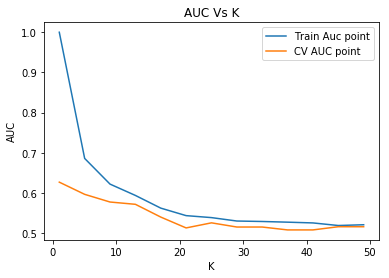

In [39]:

final_xtr = count_vect.fit_transform(x_train)
final_xcv = count_vect.transform(x_cv)
final_xtest = count_vect.transform(x_test)
auc_cv = []
auc_train = []
k = list(range(1,50,4))
cv_scores = []
for i in k:
    knn = KNeighborsClassifier(n_neighbors=i,weights='uniform',algorithm='brute',p=2,leaf_size=30,metric='cosine')
    knn.fit(final_xtr,y_train)
    pred = knn.predict(final_xcv)
    auc_cv.append(roc_auc_score(y_cv,pred))
    pred1 = knn.predict(final_xtr)
    
    auc_train.append(roc_auc_score(y_train,pred1))
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(k,auc_train,label="Train Auc point")
ax.plot(k,auc_cv,label = "CV AUC point")
plt.title("AUC Vs K")
plt.xlabel('K')
plt.ylabel('AUC')
ax.legend()
plt.show()


We found the best k = 49

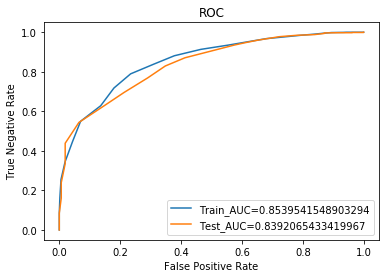

In [40]:
knn = KNeighborsClassifier(n_neighbors=49,weights='uniform',algorithm='brute',leaf_size=30,p=2,metric='cosine')
knn.fit(final_xtr,y_train)
pred1 = knn.predict_proba(final_xtr)[:,1]
fpr1,tpr1,threshold1 = metrics.roc_curve(y_train,pred1)

pred2 = knn.predict_proba(final_xtest)[:,1]

fpr2,tpr2,threshold2 = metrics.roc_curve(y_test,pred2)

plt.plot(fpr1,tpr1,label = "Train_AUC="+str(roc_auc_score(y_train,pred1)))
plt.plot(fpr2,tpr2,label = "Test_AUC="+str(roc_auc_score(y_test,pred2)))

plt.title("ROC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Negative Rate")
plt.legend()
plt.show()

#### Confusion Matrix

In [41]:
knn = KNeighborsClassifier(n_neighbors=49,weights='uniform',algorithm='brute',leaf_size=30,p=2,metric='cosine')
knn.fit(final_xtr,y_train)
pred1 = knn.predict(final_xtest)
confusion_mat = confusion_matrix(y_test,pred1)
confusion_mat

array([[  6, 149],
       [  2, 842]], dtype=int64)

Observation : We found the true negative 5,false negative 1 ,false positive 150 and true positive 843

#### Let's find f1_score

In [42]:
print("F1 score=",f1_score(y_test,pred1))

F1 score= 0.9177111716621252


In [43]:
print("accuracy=",accuracy_score(y_test,pred1))

accuracy= 0.8488488488488488


#### Apply Knn on Bi-gram

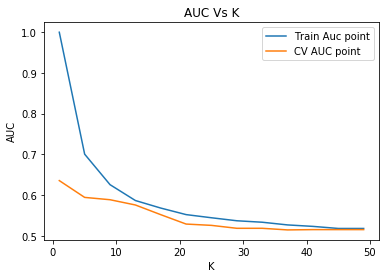

In [44]:
final_xtr_bi_gram = count_vect_bigram.fit_transform(x_train)
final_xcv_bi_gram = count_vect_bigram.transform(x_cv)
final_xtest_bi_gram = count_vect_bigram.transform(x_test)
auc_cv = []
auc_train = []
k = list(range(1,50,4))
cv_scores = []
for i in k:
    knn = KNeighborsClassifier(n_neighbors=i,weights='uniform',algorithm='brute',p=2,leaf_size=30,metric='cosine')
    knn.fit(final_xtr_bi_gram,y_train)
    pred = knn.predict(final_xcv_bi_gram)
    auc_cv.append(roc_auc_score(y_cv,pred))
    pred1 = knn.predict(final_xtr_bi_gram)
    
    auc_train.append(roc_auc_score(y_train,pred1))
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(k,auc_train,label="Train Auc point")
ax.plot(k,auc_cv,label = "CV AUC point")
plt.title("AUC Vs K")
plt.xlabel('K')
plt.ylabel('AUC')
ax.legend()
plt.show()

best k = 49

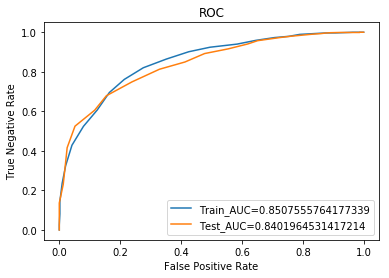

In [45]:
knn = KNeighborsClassifier(n_neighbors=49,weights='uniform',algorithm='brute',leaf_size=30,p=2,metric='cosine')
knn.fit(final_xtr_bi_gram,y_train)
pred1 = knn.predict_proba(final_xtr_bi_gram)[:,1]
fpr1,tpr1,threshold1 = metrics.roc_curve(y_train,pred1)

pred2 = knn.predict_proba(final_xtest_bi_gram)[:,1]

fpr2,tpr2,threshold2 = metrics.roc_curve(y_test,pred2)

plt.plot(fpr1,tpr1,label = "Train_AUC="+str(roc_auc_score(y_train,pred1)))
plt.plot(fpr2,tpr2,label = "Test_AUC="+str(roc_auc_score(y_test,pred2)))

plt.title("ROC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Negative Rate")
plt.legend()
plt.show()

In [46]:
knn = KNeighborsClassifier(n_neighbors=49,weights='uniform',algorithm='brute',leaf_size=30,p=2,metric='cosine')
knn.fit(final_xtr_bi_gram,y_train)
pred1 = knn.predict(final_xtest_bi_gram)
confusion_mat = confusion_matrix(y_test,pred1)
confusion_mat

array([[  6, 149],
       [  1, 843]], dtype=int64)

Observation : We found the true negative 6,false negative : 1, false positive : 149 and true positive :843

In [47]:
print("f1_score",f1_score(y_test,pred1))

f1_score 0.9183006535947713


#### Apply KNN on TF-IDF

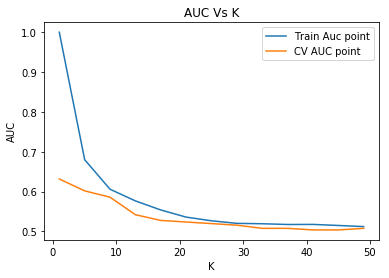

In [48]:
final_xtr_tf = tf_idf_vect.fit_transform(x_train)
final_xcv_tf = tf_idf_vect.transform(x_cv)
final_xtest_tf = tf_idf_vect.transform(x_test)
auc_cv = []
auc_train = []
k = list(range(1,50,4))
cv_scores = []
for i in k:
    knn = KNeighborsClassifier(n_neighbors=i,weights='uniform',algorithm='brute',p=2,leaf_size=30,metric='cosine')
    knn.fit(final_xtr_tf,y_train)
    pred = knn.predict(final_xcv_tf)
    auc_cv.append(roc_auc_score(y_cv,pred))
    pred1 = knn.predict(final_xtr_tf)
    
    auc_train.append(roc_auc_score(y_train,pred1))
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(k,auc_train,label="Train Auc point")
ax.plot(k,auc_cv,label = "CV AUC point")
plt.title("AUC Vs K")
plt.xlabel('K')
plt.ylabel('AUC')
ax.legend()
plt.show()

Observation : We have observed the distance between train_curve and  cross validation curve is very less on k =28, so this is our 
    best K  value

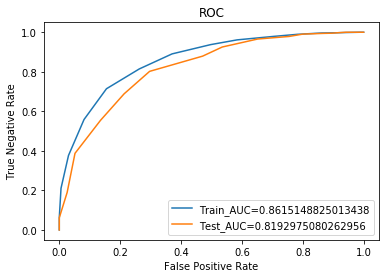

In [49]:
knn = KNeighborsClassifier(n_neighbors=28,weights='uniform',algorithm='brute',leaf_size=30,p=2,metric='cosine')
knn.fit(final_xtr_tf,y_train)
pred1 = knn.predict_proba(final_xtr_tf)[:,1]
fpr1,tpr1,threshold1 = metrics.roc_curve(y_train,pred1)

pred2 = knn.predict_proba(final_xtest_tf)[:,1]

fpr2,tpr2,threshold2 = metrics.roc_curve(y_test,pred2)

plt.plot(fpr1,tpr1,label = "Train_AUC="+str(roc_auc_score(y_train,pred1)))
plt.plot(fpr2,tpr2,label = "Test_AUC="+str(roc_auc_score(y_test,pred2)))

plt.title("ROC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Negative Rate")
plt.legend()
plt.show()

Observation : We found the Train AUC = 0.861 and Test_AUC = 0.81

In [50]:
knn = KNeighborsClassifier(n_neighbors=49,weights='uniform',algorithm='brute',leaf_size=30,p=2,metric='cosine')
knn.fit(final_xtr_tf,y_train)
pred1 = knn.predict(final_xtest_tf)
confusion_mat = confusion_matrix(y_test,pred1)
confusion_mat

array([[  5, 150],
       [  0, 844]], dtype=int64)

Observation : The total true negative 5 , false positive 150,false negative 0 and total true positive 844

In [51]:
print("F1_score",f1_score(y_test,pred1))

F1_score 0.9183895538628944


Observation : We found good f1 score for test data

In [52]:
print("accuracy:",accuracy_score(y_test,pred1))

accuracy: 0.8498498498498499
